# Train a VAE on L1000 Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data, infer_L1000_features
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA

from tensorflow import keras


from vae import VAE
from tensorflow.keras.models import Model, Sequential
import seaborn
import tensorflow as tf


In [3]:
def remove_moa(df):
    pipes = ['AKT inhibitor|mTOR inhibitor',
            'CDK inhibitor|glycogen synthase kinase inhibitor',
            'EGFR inhibitor|protein tyrosine kinase inhibitor',
            'benzodiazepine receptor agonist|HDAC inhibitor',
            'FGFR inhibitor|VEGFR inhibitor']  
    moas =  []
    for pipe in pipes:
        moas.append(pipe)
        moas.append(pipe.split('|')[0])
        moas.append(pipe.split('|')[1])
    return df[~df.moa.isin(moas)]

In [4]:
data_splits = ["train", "valid", "test", "complete"]
data_dict = load_data(data_splits, dataset="L1000")

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
# Prepare data for training
meta_features = infer_L1000_features(data_dict["train"], metadata=True)
profile_features = infer_L1000_features(data_dict["train"])

moa_df_train = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_id').reindex(index=data_dict['train']['pert_id']).reset_index().drop('pert_id',axis = 1)
data_dict['train'] = pd.concat([moa_df_train,data_dict['train']], axis=1)

moa_df_valid = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_id').reindex(index=data_dict['valid']['pert_id']).reset_index().drop('pert_id',axis = 1)
data_dict['valid'] = pd.concat([moa_df_valid,data_dict['valid']], axis=1)

data_dict['train'] = remove_moa(data_dict['train'])
data_dict['valid'] = remove_moa(data_dict['valid'])

train_features_df = data_dict["train"].reindex(profile_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(profile_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(profile_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(profile_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [8]:
print(train_features_df.shape)
train_features_df.head(3)

(89185, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,0.74578,-0.007757,-0.063908,-0.115210,0.83776,-0.80023,-0.25787,-0.621180,-0.53313,-0.260430,...,-0.458550,0.51684,2.86550,-0.152210,-0.907810,1.47600,-0.42918,-0.81612,0.28533,0.37183
1,-0.29710,-0.180930,0.482090,-0.337130,-0.47045,-0.44483,0.38475,-0.566390,0.27726,0.000645,...,0.008161,-0.33238,-0.20174,-0.605390,0.024792,0.60759,0.41555,0.50640,0.23908,-0.23696
2,-0.75812,-0.283820,0.594330,0.089136,-0.85230,-0.78754,0.20291,0.018564,-0.22745,-0.839810,...,0.289560,0.16598,0.54440,-0.053607,0.439350,0.42920,-0.37040,-0.51931,-0.21799,-1.29360


In [9]:
print(valid_features_df.shape)
valid_features_df.head(3)

(11164, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,-0.534400,0.552700,0.000000,-0.95760,-0.3264,-0.25560,0.00000,0.00000,1.88250,1.86290,...,5.22050,-0.96970,-1.133800,-1.079700,-2.29810,0.8493,0.29560,0.84640,0.19020,-0.47540
1,-0.029159,0.039928,0.045024,0.26740,-1.0234,0.58926,0.57561,0.60793,0.33281,-0.65153,...,-0.25789,0.46169,0.022211,-0.035998,0.67575,2.2909,0.24359,-0.14676,-0.84884,-0.16919
2,0.365290,-1.311300,-0.153500,0.72378,-1.1094,-0.38681,1.05910,0.12169,-1.01300,0.83094,...,-0.22982,-0.21314,-0.088198,0.527700,0.49855,-1.3877,1.00980,-0.21835,0.16329,-0.79029


In [10]:
print(test_features_df.shape)
test_features_df.head(3)

(11805, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,0.28158,1.6038,-1.58650,-0.41677,-2.34260,3.12320,-0.10233,1.62600,0.115840,-0.000233,...,-0.49069,-1.14930,-0.16539,0.49864,1.077800,1.66230,-1.66900,-0.49738,0.51629,1.08940
1,0.77369,1.0853,0.75758,1.04900,1.18270,0.69324,-0.43503,-0.88949,-0.075833,0.208990,...,0.10747,0.97814,0.85407,0.10528,-0.370430,0.89069,-0.26969,-0.98646,-1.07350,0.48240
2,0.63079,1.9072,-1.65190,0.26266,0.68423,-0.38400,1.63160,0.78741,0.732920,-2.431700,...,-1.83770,-0.56064,0.93692,0.96585,-0.036786,1.35430,2.15870,-0.28158,0.53111,-0.46053


In [11]:
print(complete_features_df.shape)
complete_features_df.head(3)

(118050, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,4.26410,0.057249,-2.13930,-0.22178,-0.37656,1.91380,0.065576,-0.86895,-0.10227,0.00000,...,5.246200,0.057058,-1.25620,-0.025255,0.168860,-1.639100,0.68510,-0.41942,1.71610,-0.47234
1,-0.38221,0.304310,-0.99592,-0.67083,-0.64824,0.62161,0.889530,0.20376,0.19481,-0.45637,...,0.206690,-0.010866,-0.87206,-0.223750,0.074144,0.093595,0.32667,1.04810,-0.50518,-0.61832
2,-0.57171,-0.755000,-0.71011,0.42889,0.27261,0.31436,-1.545800,0.64195,-0.87685,0.00000,...,-0.005612,1.194500,0.17111,0.334370,-1.089300,-0.114640,0.30483,-0.24947,-0.42835,1.58500


In [12]:

encoder_architecture = [500]
decoder_architecture = [500]


In [13]:

L1000_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=65,
    batch_size=512,
    encoder_batch_norm=True,
    epochs=180,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=40,
    verbose=True,
)

L1000_vae.compile_vae()


In [14]:
L1000_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/180
175/175 [==============================] - 18s 89ms/step - loss: 2229.5557 - recon: 1612.0594 - kl: 314.1814 - val_loss: 1741.4204 - val_recon: 1511.1177 - val_kl: 230.3028
Epoch 2/180
175/175 [==============================] - 15s 83ms/step - loss: 1707.2051 - recon: 1495.7096 - kl: 181.6769 - val_loss: 1640.7230 - val_recon: 1466.7916 - val_kl: 173.9310
Epoch 3/180
175/175 [==============================] - 14s 83ms/step - loss: 1631.5290 - recon: 1458.1951 - kl: 157.4922 - val_loss: 1597.2996 - val_recon: 1444.3007 - val_kl: 152.9987
Epoch 4/180
175/175 [==============================] - 14s 82ms/step - loss: 1586.7495 - recon: 1433.3481 - kl: 146.9596 - val_loss: 1563.9631 - val_recon: 1417.4020 - val_kl: 146.5610
Epoch 5/180
175/175 [==============================] - 14s 82ms/step - loss: 1563.0756 - recon: 1415.3558 - kl: 141.0279 - val_loss: 1543.5142 - val_recon: 1403.5820 - val_kl: 139.9321
Epoch 6/180
175/175 [==============================] - 13s 77ms/step - loss

175/175 [==============================] - 4s 22ms/step - loss: 1349.4118 - recon: 1218.4553 - kl: 129.1026 - val_loss: 1348.0862 - val_recon: 1218.5657 - val_kl: 129.5206
Epoch 90/180
175/175 [==============================] - 4s 23ms/step - loss: 1343.9056 - recon: 1214.6945 - kl: 129.1229 - val_loss: 1351.6146 - val_recon: 1222.2905 - val_kl: 129.3241
Epoch 91/180
175/175 [==============================] - 6s 32ms/step - loss: 1342.9552 - recon: 1215.8348 - kl: 129.3074 - val_loss: 1352.7661 - val_recon: 1220.0573 - val_kl: 132.7090
Epoch 92/180
175/175 [==============================] - 10s 56ms/step - loss: 1341.2351 - recon: 1215.1337 - kl: 129.2467 - val_loss: 1350.4645 - val_recon: 1221.4790 - val_kl: 128.9855
Epoch 93/180
175/175 [==============================] - 10s 56ms/step - loss: 1340.0156 - recon: 1214.1909 - kl: 129.1481 - val_loss: 1353.8932 - val_recon: 1222.3458 - val_kl: 131.5471
Epoch 94/180
175/175 [==============================] - 9s 50ms/step - loss: 1343.1717

175/175 [==============================] - 10s 57ms/step - loss: 1331.8614 - recon: 1202.0636 - kl: 130.8333 - val_loss: 1343.6411 - val_recon: 1212.2765 - val_kl: 131.3644
Epoch 134/180
175/175 [==============================] - 10s 55ms/step - loss: 1335.5108 - recon: 1203.6106 - kl: 130.4428 - val_loss: 1340.8978 - val_recon: 1209.9821 - val_kl: 130.9157
Epoch 135/180
175/175 [==============================] - 10s 55ms/step - loss: 1333.6127 - recon: 1202.7673 - kl: 130.8477 - val_loss: 1341.7317 - val_recon: 1213.3824 - val_kl: 128.3490
Epoch 136/180
175/175 [==============================] - 10s 55ms/step - loss: 1332.8969 - recon: 1202.3394 - kl: 130.4860 - val_loss: 1339.8118 - val_recon: 1209.0109 - val_kl: 130.8010
Epoch 137/180
175/175 [==============================] - 9s 53ms/step - loss: 1328.7002 - recon: 1202.9762 - kl: 130.4245 - val_loss: 1341.8264 - val_recon: 1210.7499 - val_kl: 131.0766
Epoch 138/180
175/175 [==============================] - 9s 54ms/step - loss: 13

Epoch 177/180
175/175 [==============================] - 10s 56ms/step - loss: 1330.7149 - recon: 1194.9989 - kl: 131.7309 - val_loss: 1335.8840 - val_recon: 1202.6654 - val_kl: 133.2185
Epoch 178/180
175/175 [==============================] - 10s 55ms/step - loss: 1325.6813 - recon: 1193.5763 - kl: 131.5910 - val_loss: 1335.0234 - val_recon: 1200.8491 - val_kl: 134.1742
Epoch 179/180
175/175 [==============================] - 10s 55ms/step - loss: 1329.1780 - recon: 1194.2125 - kl: 131.8550 - val_loss: 1334.7096 - val_recon: 1203.5747 - val_kl: 131.1348
Epoch 180/180
175/175 [==============================] - 10s 57ms/step - loss: 1328.6406 - recon: 1193.9304 - kl: 131.8166 - val_loss: 1333.8988 - val_recon: 1200.6348 - val_kl: 133.2641


In [15]:
    L1000_vae.vae

In [16]:
# Save training performance
history_df = pd.DataFrame(L1000_vae.vae.history.history)
history_df


,loss,recon,kl,val_loss,val_recon,val_kl
0,1926.240479,1612.059448,314.181366,1741.420410,1511.117676,230.302826
1,1677.386475,1495.709595,181.676941,1640.723022,1466.791626,173.931046
2,1615.687134,1458.195068,157.492218,1597.299561,1444.300659,152.998672
3,1580.307495,1433.348145,146.959641,1563.963135,1417.401978,146.560959
4,1556.383667,1415.355835,141.027924,1543.514160,1403.582031,139.932144
...,...,...,...,...,...,...
175,1325.170288,1193.483521,131.686798,1334.782227,1203.375977,131.406143
176,1326.729980,1194.998901,131.730927,1335.884033,1202.665405,133.218475
177,1325.167725,1193.576294,131.591003,1335.023438,1200.849121,134.174179
178,1326.067383,1194.212524,131.855026,1334.709595,1203.574707,131.134781


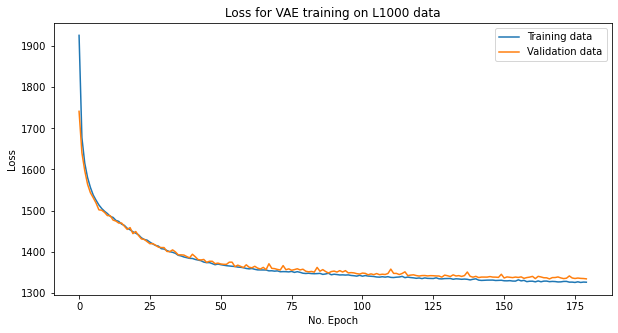

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on L1000 data")
plt.ylabel("Loss")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [19]:
# evaluating performance using test set
L1000_vae.vae.evaluate(test_features_df)

369/369 [==============================] - 2s 5ms/step - loss: 1348.7585 - recon: 1212.8306 - kl: 135.9285


[1348.758544921875, 1212.83056640625, 135.9285430908203]

In [24]:
reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

3781.6119246529884

<AxesSubplot:>

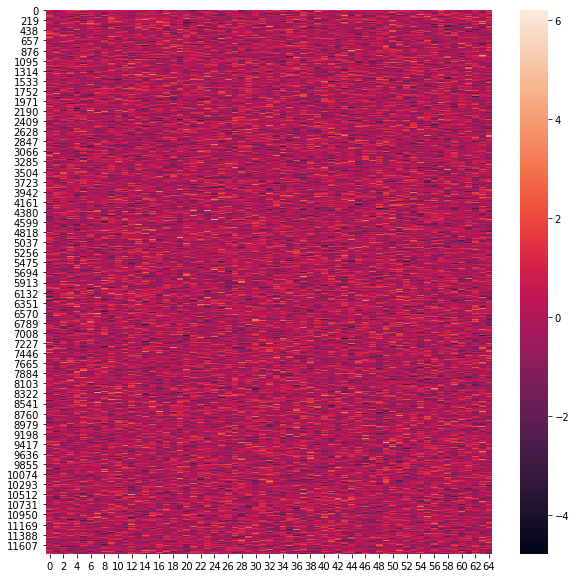

In [25]:
# latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = L1000_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [26]:


reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)

pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))


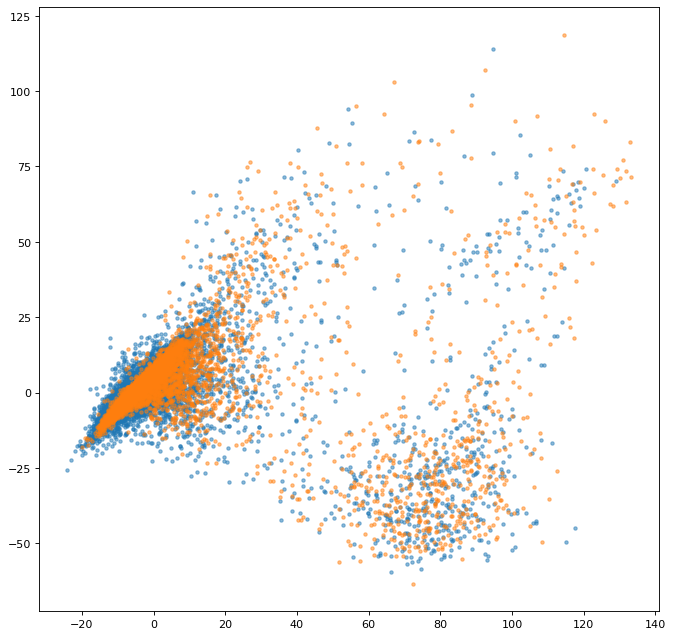

In [27]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)


In [30]:
decoder = L1000_vae.decoder_block["decoder"]


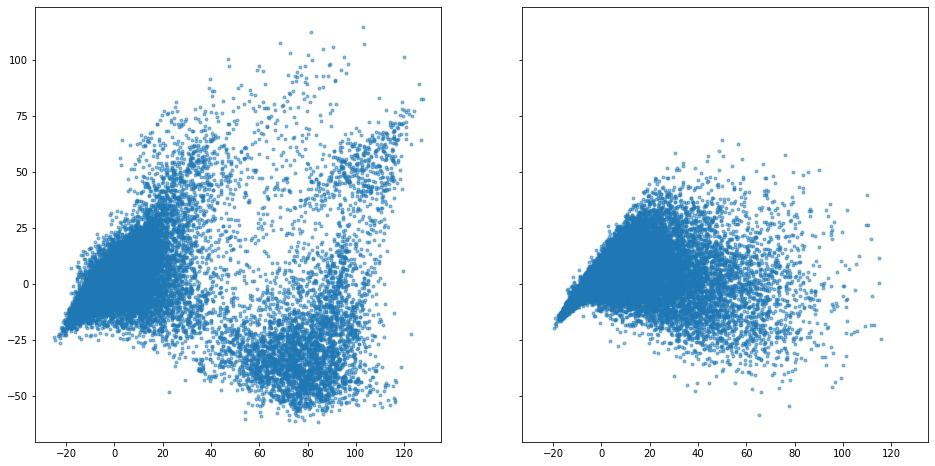

In [31]:
pca_training = PCA(n_components=2).fit(train_features_df)

simulated_df = pd.DataFrame(np.random.normal(size=(94440, 65)), columns=np.arange(0,65))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca_training.transform(reconstruction_of_simulated))
pca_train_latent_df = pd.DataFrame(pca_training.transform(train_features_df))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_train_latent_df[0],pca_train_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [32]:
from scipy.spatial.distance import directed_hausdorff
max(directed_hausdorff(reconstruction_of_simulated, train_features_df)[0],directed_hausdorff(train_features_df,reconstruction_of_simulated)[0])

194.0197004005436

In [33]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/latentTwoLayer_leaveOut.csv")

In [34]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save('./models/L1000twolayerDecoder_leaveOut')

INFO:tensorflow:Assets written to: ./L1000twolayerDecoder_leaveOut/assets


In [35]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
encoder.save('./models/L1000twolayerEncoder_leaveOut')

INFO:tensorflow:Assets written to: ./L1000twolayerEncoder_leaveOut/assets
